### Temperature Animation

Create an animation of the surface temperature across the entire AUS2200 domain for a complete simulation in parallel using Xarray.

In [ ]:
import xarray as xr
from glob import glob
from dask.distributed import Client
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
file_list = sorted(glob('/g/data/gx60/dr4292/experiments/ECL-shifted-evolvingSST/netcdf/u-cs142-20160603T0000-continuous-140E-evolvingSST/*/aus2200/d0198/RA3/um/umnsa_spec*'))

In [3]:
client=Client()
client

2024-06-11 12:23:33,952 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-11 12:23:33,984 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-11 12:23:34,048 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-spr-0098.gadi.nci.org.au/52617/proxy/8787/status,
Dashboard: /node/gadi-cpu-spr-0098.gadi.nci.org.au/52617/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35419,Workers: 4
Dashboard: /node/gadi-cpu-spr-0098.gadi.nci.org.au/52617/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39799,Total threads: 1
Dashboard: /node/gadi-cpu-spr-0098.gadi.nci.org.au/52617/proxy/35585/status,Memory: 0 B
Nanny: tcp://127.0.0.1:45567,


In [4]:
mf_ds = xr.open_mfdataset(file_list,preprocess=lambda x: x['fld_s00i024'],parallel=True,chunks={'lat':-1,'lon':-1})

In [5]:
mf_ds

<xarray.Dataset> Size: 16GB
Dimensions:                   (time: 720, lat: 2120, lon: 2600)
Coordinates:
  * time                      (time) datetime64[ns] 6kB 2016-06-03T00:10:00 ....
  * lat                       (lat) float64 17kB -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 21kB 114.3 114.3 ... 165.7 165.7
    theta_level_height        float64 8B 5.0
    model_theta_level_number  int32 4B 1
    sigma_theta               float64 8B 0.9994
    height                    float64 8B 10.0
    height_0                  float64 8B 1.5
Data variables:
    fld_s00i024               (time, lat, lon) float32 16GB dask.array<chunksize=(1, 2120, 2600), meta=np.ndarray>

In [6]:
def make_frame(f,ts,i,lat,lon):
    fig = plt.figure()
    ax=fig.add_subplot(111)
    pc = ax.pcolormesh(lon,lat,f - 273.15,shading='nearest',vmin=-5,vmax=45)
    fig.colorbar(pc,label="Surface Temperature (°C)")
    t = pd.to_datetime(ts)
    plt.title(str(ts))
    plt.savefig(f'/home/563/dr4292/animation/frame{i:04}.png')
    return i

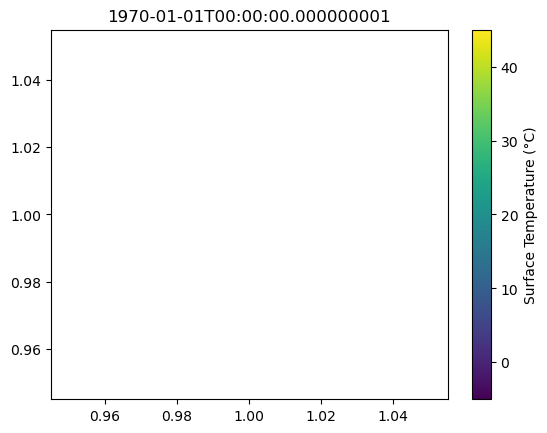

In [7]:
out = xr.apply_ufunc(make_frame,
    mf_ds['fld_s00i024'],
    mf_ds['fld_s00i024'].time,
    xr.DataArray([i for i in range(720)],{'time':mf_ds.time}),
    mf_ds['fld_s00i024'].lat,
    mf_ds['fld_s00i024'].lon,
    input_core_dims=[['lat','lon'],[],[],['lat',],['lon',]],
    exclude_dims=set(("lat","lon")),
    vectorize=True,
    dask="parallelized"
)
#for i,f in enumerate(mf_ds['fld_s00i024']):
#    f.plot(vmin=260, vmax=350)
#    plt.savefig(f'/home/563/dr4292/animation/frame{i:04}.png')
#    plt.close()

In [ ]:
out.compute()

In [ ]:
!ffmpeg -framerate 10 -pattern_type glob -i '/home/563/dr4292/animation/frame*.png' -c:v libx264 -r 30 -pix_fmt yuv420p output.mp4